In [12]:
import os
import io
import json
import csv
import random
import numpy as np
from PIL import Image
import lmdb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import torch.nn as nn
from torchsummary import summary

In [2]:
# Use MPS (Apple GPU) if available; otherwise, fall back to CPU
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#DEVICE = torch.device("cuda")

# Using consolidated training data
1. Legibility
2. Digit classification

Run the following cell to create merged ground truths:

In [3]:
# File paths (update these as needed)
txt_file_path = "./data/SoccerNetLegibility/train/train_gt.txt" #legibility ground truth (frame level)
json_file_path = "./data/train_gt_numbers.json" #numbers ground truth (tracklet level)
output_file_path = "./data/merged_ground_truths.csv"

# Step 1: Load legibility ground truths from TXT file
legibility_data = {}

with open(txt_file_path, "r") as txt_file:
    for line in txt_file:
        parts = line.strip().split(",")
        frame_name = parts[0].strip(".jpg")  # Format: trackletID_frameID.jpg
        legibility = int(parts[1])  # 0 or 1
        legibility_data[frame_name] = legibility

# Step 2: Load jersey number ground truths from JSON file
with open(json_file_path, "r") as json_file:
    jersey_numbers = json.load(json_file)  # Dictionary: {"trackletID": jersey_number}

# Step 3: Merge data and write to output file
with open(output_file_path, "w") as output_file:
    for frame_name, legibility in legibility_data.items():
        tracklet_id = frame_name.split("_")[0]  # Extract tracklet number
        jersey_number = jersey_numbers.get(tracklet_id, -1)  # Default to -1 if not found
        output_file.write(f"{frame_name}, {legibility}, {jersey_number}\n")

print(f"Merged ground truths saved to {output_file_path}")


Merged ground truths saved to ./data/merged_ground_truths.csv


In [4]:
def compute_image_dimensions(img_dir="./data/imgs"):
    widths = []
    heights = []
    
    # Iterate over files in the directory
    for filename in os.listdir(img_dir):
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(img_dir, filename)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    if not widths or not heights:
        print("No images processed successfully.")
        return None
    
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    min_width = np.min(widths)
    max_width = np.max(widths)
    min_height = np.min(heights)
    max_height = np.max(heights)
    
    print("Average width:", avg_width)
    print("Average height:", avg_height)
    print("Min width:", min_width)
    print("Max width:", max_width)
    print("Min height:", min_height)
    print("Max height:", max_height)

In [5]:
compute_image_dimensions("./data/SoccerNetLegibility/train/images")

Average width: 49.01357229158276
Average height: 104.46041079339508
Min width: 1
Max width: 179
Min height: 2
Max height: 255


In [13]:
def pad_to_square(image):
    """Pads an image to make it square using reflection padding."""
    w, h = image.size  # Get width and height
    max_dim = max(w, h)
    
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2

    return F.pad(image, (pad_w, pad_h, pad_w, pad_h), padding_mode="reflect")

In [14]:
# Updated Preprocessing Pipeline
transform = transforms.Compose([
    transforms.Resize(128),  # Resize height to 128, maintaining aspect ratio
    transforms.Lambda(pad_to_square),  # Pad to make it a square
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),  # Final resize
    transforms.ToTensor()  # Convert to PyTorch tensor
])

In [7]:
# Loading ground truths
# For each cropped jersey number image (named as <tracklet>_<frame>.jpg), it extracts the <tracklet> part from the name   
# and looks up its ground truth in the JSON file, loads the image, performs transformations, and appends it to a list.

def load_merged_data(img_dir="./data/SoccerNetLegibility/train/images", gt_file="./data/merged_ground_truths.csv"):
    # Load the ground truths into a dictionary
    gt_data = {}

    with open(gt_file, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            frame_id = row[0].strip()  # tracklet_number_frame_id
            legibility = int(row[1].strip())  # 0 or 1
            jersey_number = int(row[2].strip())  # -1 or 1 to 99
            gt_data[frame_id] = (legibility, jersey_number)


    images = []
    labels = []
    
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            # key = filename.split("_")[0]  # Extract tracklet ID from filename
            # label = gt_data[key]

            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path).convert("RGB")  
                img_tensor = transform(img)  
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue 
            
            images.append(img_tensor)

            key = filename.split(".")
            label = gt_data[key[0]]

            # we use separate labels for legibility and jersey number (so the model will have to output them separately)
            if label[1] == -1 or label[0] == 0:
                labels.append([0, 0])   
            else:
                labels.append(label)

    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)  # return Tensors


In [8]:
# Load images and labels from merged_ground_truths.csv file for single-loss
def load_data_csv(img_dir="./data/SoccerNetLegibility/train/images", gt_file="./data/merged_ground_truths.csv"):
    # Load the ground truths into a dictionary
    gt_data = {}

    with open(gt_file, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            frame_id = row[0].strip()  # tracklet_number_frame_id
            jersey_number = int(row[2].strip())  # -1 or 1 to 99
            gt_data[frame_id] = jersey_number


    images = []
    labels = []
    
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            # key = filename.split("_")[0]  # Extract tracklet ID from filename
            # label = gt_data[key]

            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path).convert("RGB")  
                img_tensor = transform(img)  
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue 
            
            images.append(img_tensor)

            key = filename.split(".")
            label = gt_data[key[0]]

            if label == -1:
                labels.append(0)   
            else:
                labels.append(label)

    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)  # return Tensors

In [ ]:
# Load images and labels in the format: <legibility>, <jersey number>
# images, labels = load_merged_data()

# Load images just using the number as the ground truth:
images, labels = load_data_csv()

In [10]:
dataset = TensorDataset(images, labels)

# 95-5 train-test split
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# For initial model testing, try to overfit to a small subset of the training data to see if the model has sufficient complexity
small_train_size = int(0.15 * len(train_dataset))
small_indices = random.sample(range(len(train_dataset)), small_train_size)
small_train_dataset = torch.utils.data.Subset(train_dataset, small_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Small test dataset size: {len(small_train_dataset)}")

Total dataset size: 24830
Train dataset size: 23588
Test dataset size: 1242
Small test dataset size: 3538


# Visualizing the dataset

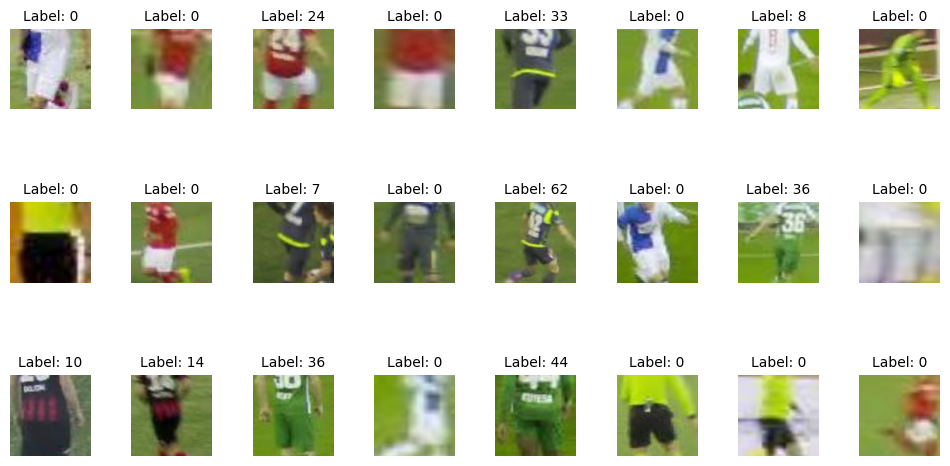

In [11]:
image_batch, label_batch = next(iter(train_loader))  # Get the next batch from the train loader

num_cols = 8
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    ax = axes[i]
    image = image_batch[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    # image = image * 1 + 0  
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label_batch[i].item()}', fontsize=10)
    ax.axis('off')  # Turn off the axes for each subplot

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [ ]:
def plot_label_histogram(labels, title="", multi_label=False):

    if multi_label:
        # Convert the tens and ones digits back to the original labels
        labels_as_int = [tens * 10 + ones if tens != 10 and ones != 10 else 0 for tens, ones in labels]
    else:
        labels_as_int = [int(label) for label in labels]
    
    # Set up the bins so that each integer gets its own bar
    bins = np.arange(0, 100 + 2)  # +2 so that the upper value is included
    plt.figure(figsize=(13, 8))
    plt.hist(labels_as_int, bins=bins, edgecolor='black', align='left')
    plt.xlabel("Ground Truth Number")
    plt.ylabel("Frequency")
    if title:
        plt.title(title)
    else:
        plt.title(f"Histogram of Ground Truth Numbers (0-99)")
    plt.xticks(np.arange(0, 100 + 1, step=2))  
    plt.show()

In [ ]:
plot_label_histogram(labels)

# Training the model

In [13]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 64x64 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 inputs
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 inputs
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 inputs 
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 4x4 inputs
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 2x2 inputs
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 1x1 inputs
        self.fc = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 8192),   # output of last conv block is 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.fc(x)
        return x


In [ ]:
net = JerseyNumberClassifier()
summary(net, (3,64,64))

In [ ]:
def training_loop(model, optimizer, criterion, epochs, train_loader, device ):
    total_train_losses = []
    total_train_acc = []

    for epoch in range(epochs):

        total_loss_in_epoch = 0
        correct_preds = 0
        total_preds = 0

        # Training 
        for inputs, ground_truths in train_loader:

            inputs = inputs.to(device)
            ground_truths = ground_truths.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)    
            loss = criterion(outputs, ground_truths)     
            loss.backward()
            optimizer.step()

            total_loss_in_epoch += loss.item()       # accumulate loss for this batch
            correct_preds += (torch.argmax(outputs, dim=1) == ground_truths).sum().item()
            total_preds += outputs.size(0)

        # average out the loss and accuracy across the batch
        avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
        train_accuracy = round((correct_preds / total_preds) * 100, 4)

        total_train_losses.append(avg_train_loss)
        total_train_acc.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
        print("=" * 20)


In [ ]:
def evaluate_model (model, test_loader, device):
  model.eval()

  correct = 0
  total = 0

  #disable gradient computation
  with torch.no_grad():
    # iterate over test batches
    for inputs, labels in test_loader:
      # moving inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)

      #forward pass
      outputs = model(inputs)

      #get prediction
      _, predicted = torch.max(outputs, 1)

      # update total samples and correct predictions
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  #compute accuracy
  accuracy = 100 * correct/total
  print(f"Test Accuracy: {accuracy:.2f}%")
  print(f"correct predictions: {correct}/{total}")

In [ ]:
net.to(DEVICE)

In [ ]:
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
training_loop(net, optimizer, criterion, epochs, small_train_loader, DEVICE)